In [40]:
import pandas as pd
import string
import re

with open("songs/dylan_corpus.txt", "r", encoding="utf-8") as f:
    dylan_text = f.read()

with open("songs/swift_corpus.txt", "r", encoding="utf-8") as f:
    swift_text = f.read()

# teilt Texte in Zeilen auf und entfernt leere Zeilen
dylan_lines = [l.strip() for l in dylan_text.splitlines() if l.strip()]
swift_lines = [l.strip() for l in swift_text.splitlines() if l.strip()]

data = pd.DataFrame({
    "lyrics": dylan_lines + swift_lines,
    "label":  ["dylan"] * len(dylan_lines) + ["swift"] * len(swift_lines)
})

print(data.head())

# Cleaning
def clean(text: str) -> str:
    text = text.lower()                                                 # klein schreiben
    text = re.sub(r"\d+", " ", text)                                    # Ziffern entfernen
    text = text.translate(str.maketrans("", "", string.punctuation))    # Satzzeichen raus
    text = re.sub(r"\s+", " ", text).strip()                            # Mehrfach-Leerzeichen
    return text

# clean Fkt für  jede Zeile
data["cleaned_lyrics"] = data["lyrics"].apply(clean)

# Speichern der bereinigten Daten
data.to_csv("lyrics_cleaned.csv", index=False)

                                              lyrics  label
0  talking new york ramblin outa the wild west le...  dylan
1  song to woody im out here a thousand miles fro...  dylan
2  hard times in new york town come you ladies an...  dylan
3  talking bear mountain picnic massacre blues i ...  dylan
4  rambling gambling willie come around you rovin...  dylan


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# übersetzt POS-Tags in passende WordNet-Tags
def get_wordnet_pos(tag: str):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

data = pd.read_csv("lyrics_cleaned.csv")

def tokenize_and_lemmatize(text: str) -> str:
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    pos_tags = nltk.pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]

    return " ".join(lemmas)

data["preprocessed_lyrics"] = data["cleaned_lyrics"].apply(tokenize_and_lemmatize)

print(data[["label", "preprocessed_lyrics"]].head())

# Speichern der vorverarbeiteten Daten
data.to_csv("lyrics_preprocessed.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import joblib  # zum Speichern des Modells

data = pd.read_csv("lyrics_preprocessed.csv")
print(data.head())

X_text = data["preprocessed_lyrics"]
y = data["label"]

# erstellt Bag-of-Words, lernt Vokabular
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_text)

# Teilt in Trainings- und Testdaten (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Naive Bayes 
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Speichern des Modells und des Vectorizers
joblib.dump(vectorizer, "vectorizer.joblib")
joblib.dump(clf, "naive_bayes_lyrics.joblib")
joblib.dump((X_test, y_test), "test_data.joblib")
print("Modell, Vectorizer und Testdaten gespeichert.")


                                              lyrics  label  \
0  talking new york ramblin outa the wild west le...  dylan   
1  song to woody im out here a thousand miles fro...  dylan   
2  hard times in new york town come you ladies an...  dylan   
3  talking bear mountain picnic massacre blues i ...  dylan   
4  rambling gambling willie come around you rovin...  dylan   

                                      cleaned_lyrics  \
0  talking new york ramblin outa the wild west le...   
1  song to woody im out here a thousand miles fro...   
2  hard times in new york town come you ladies an...   
3  talking bear mountain picnic massacre blues i ...   
4  rambling gambling willie come around you rovin...   

                                 preprocessed_lyrics  
0  talk new york ramblin outa wild west leavin to...  
1  song woody im thousand mile home walkin road m...  
2  hard time new york town come lady gentleman al...  
3  talk bear mountain picnic massacre blue saw ad...  
4  ramble

Confusion Matrix (rows=true, cols=predicted):
['dylan', 'swift']
[[70  8]
 [ 1 34]]

Classification Report:
              precision    recall  f1-score   support

       dylan       0.99      0.90      0.94        78
       swift       0.81      0.97      0.88        35

    accuracy                           0.92       113
   macro avg       0.90      0.93      0.91       113
weighted avg       0.93      0.92      0.92       113



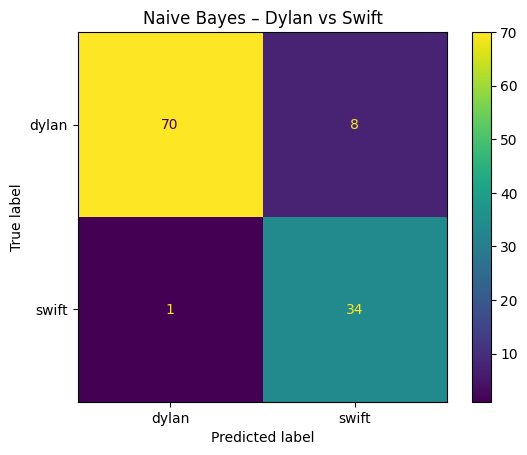


Top 20 Wörter für dylan:
['get' 'im' 'say' 'well' 'go' 'know' 'dont' 'come' 'like' 'see' 'na' 'one'
 'time' 'man' 'gon' 'love' 'youre' 'aint' 'tell' 'make']

Top 20 Wörter für swift:
['know' 'im' 'get' 'say' 'dont' 'like' 'oh' 'love' 'go' 'youre' 'come'
 'na' 'back' 'never' 'time' 'baby' 'think' 'cause' 'see' 'look']


In [ ]:
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

vectorizer = joblib.load("vectorizer.joblib")
clf = joblib.load("naive_bayes_lyrics.joblib")
X_test, y_test = joblib.load("test_data.joblib")

y_pred = clf.predict(X_test)

labels = ["dylan", "swift"]

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("Confusion Matrix (rows=true, cols=predicted):")
print(labels)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Naive Bayes – Dylan vs Swift")
plt.show()

feature_names = vectorizer.get_feature_names_out()

# Top-N Wörter pro Klasse
N = 20
for i, class_label in enumerate(clf.classes_):
    top_indices = np.argsort(clf.feature_log_prob_[i])[::-1][:N]
    top_words = feature_names[top_indices]
    print(f"\nTop {N} Wörter für {class_label}:")
    print(top_words)


In [38]:
print(clf.classes_)
print(len(vectorizer.get_feature_names_out()))
print("Train size:", len(y_train))
print("Test size:", len(y_test))
print(np.unique(y_test, return_counts=True))


['dylan' 'swift']
7055
Train size: 448
Test size: 113
(array(['dylan', 'swift'], dtype=object), array([78, 35]))
